In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib  #to save the trained model
np.random.seed(42)

df = pd.read_csv('adult.data.csv', header=None)
df.columns = [
    'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
    'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
    'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target'
]
df["Target"] = df["Target"].str.strip()

# Data overview:
print("Dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print(df.head())
print("\nData shape:",df.shape)
print("\nData info:")
print(df.info())


Dataset shape: (32561, 15)

Columns:
['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target']
   Age          Workclass  fnlwgt   Education  Education-Num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        Marital Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black 

### Classifier: randomforest

======================================================= classification ==================================================

2. Analyzing target(salary) distribution...

   Target distribution (%):
Target
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64
Median age: 37.0

Binarized age distribution (%):
age_binary
0    51.229999
1    48.770001
Name: proportion, dtype: float64
Columns: ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target', 'age_binary']
Feature shape: (32561, 101)
Target shape: (32561,)
Features used: ['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week', 'age_binary', 'Workclass_ Federal-gov', 'Workclass_ Local-gov', 'Workclass_ Never-worked', 'Workclass_ Private', 'Workclass_ Self-emp-inc', 'Workclass_ Self-emp-not-inc', 'Workclass_ State-gov', 'Workclass_ Without-pay', 'Education_ 

['train_test_splits.joblib']

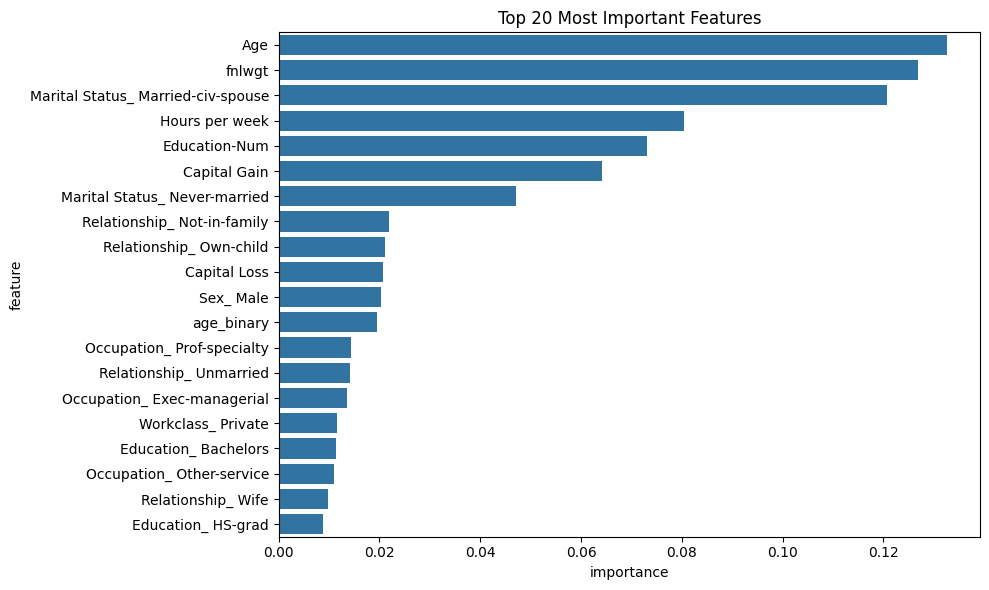

In [ ]:
print("="*55,"classification","="*50)
# Target distribution
print("\n2. Analyzing target(salary) distribution...")
print("\n   Target distribution (%):")
target_dist = df['Target'].value_counts(normalize=True) * 100
print(target_dist)

#Binarize Age
median_age = df['Age'].median()
df['age_binary'] = (df['Age'] > median_age).astype(int)
print(f"Median age: {median_age}")
print("\nBinarized age distribution (%):")
print(df['age_binary'].value_counts(normalize=True) * 100)

#data preparation
df_clean = df.copy()

print(f"Columns: {df_clean.columns.tolist()}")

# Prepare features and target cols
numerical_features = ['Education-Num', 'Hours per week', 'Age', 'Capital Gain', 'Capital Loss']
categorical_features = ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
# one hot encore categorical
df_encoded = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True)
# feature matrix X
X = df_encoded.drop('Target', axis=1)
X['age_binary'] = df['age_binary'] 
# target 1 if >50K else 0
y = (df_clean['Target'] == '>50K').astype(int)

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features used: {X.columns.tolist()}")

# Split data into train, validation, and test sets
# Training&&Test split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Training split: 60% train and 20% validation==> 0.25 * 0.8 = 0.2 of original data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  

print(f"==Training: {X_train.shape[0]}")
print(f"==Validation: {X_val.shape[0]}") 
print(f"==Test: {X_test.shape[0]}")

# Training
print("\n ========================================== Training Random Forest classifier=============================================")
classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # in case class imbalance (eg.target, see distribution in%)
)
classifier.fit(X_train, y_train)

# test set evaluation
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
# Accuracy and precision
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance: how much a feature impacts the target value
print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)


print("50 most impactful features::")
print(feature_importance.head(50))

#  feature importance plot 
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance_top20.png', dpi=300)
# Save processed dataset
df_final = X.copy()
df_final['Target'] = y
df_final.to_csv('adult_processed.csv', index=False)
# Save the trained model
joblib.dump(classifier, 'classifier_model.joblib')
joblib.dump((X_train, X_test, y_train, y_test), 'train_test_splits.joblib')
